# Training a Classifier

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/borchero/pyblaze/blob/master/examples/classifier.ipynb)
[![Download Jupyter Notebbok](https://img.shields.io/badge/Github-Download-brightgreen)](https://github.com/borchero/pyblaze/blob/master/examples/classifier.ipynb)

Training a classifier on images is one of the most prominent examples showcasing what a library can do. Inspired by PyTorch’s tutorials, we want to train a convolutional neural network on the CIFAR10 dataset using the features of PyBlaze.

At first, we import all libraries that we’re going to use throughout this example:

In [1]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import pyblaze.nn as xnn
import pyblaze.nn.functional as X
import matplotlib.pyplot as plt

%matplotlib inline

## Loading the Data

At the beginning, we load our data conveniently using torchvision. PyBlaze does not come into play yet.

In [2]:
train_val_dataset = torchvision.datasets.CIFAR10(
    root="~/Downloads/", train=True, download=True, transform=transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor()
    ])
)
test_dataset = torchvision.datasets.CIFAR10(
    root="~/Downloads/", train=False, download=True, transform=transforms.ToTensor()
)

Files already downloaded and verified
Files already downloaded and verified


### Initializing Data Loaders

First, we set aside 20% of all training data for validation. Usually, you would need to compute the sizes of the resulting subsets and then split the dataset randomly. However, using PyBlaze, you can do this more conveniently.

By simply importing `pyblaze.nn`, datasets receive an additional function `random_split`. This accepts arbitrarily many floating point numbers indicating the fraction of the dataset to be randomly sampled into subsets. Note that these numbers need to add to 1.

In [3]:
train_dataset, val_dataset = train_val_dataset.random_split(0.8, 0.2)

Finally, we can initialize the data loaders. Normally, you would initialize a data loader and pass the dataset to the initializer. Again, as soon as you import `pyblaze.nn`, we extend PyTorch’s native dataset with a `loader` method. The method creates a data loader while its parameters are the same as for PyTorch’s data loader initializer.

In [4]:
train_loader = train_dataset.loader(batch_size=256, num_workers=4, shuffle=True)
val_loader = val_dataset.loader(batch_size=2048)
test_loader = test_dataset.loader(batch_size=2048)

Note that we set the batch size for validation and testing significantly higher than for training: as we are running the model in eval mode, no gradients need to be stored and much less memory is required.

## Defining the Model

As a model, we define a common convolutional neural network. Most importantly, defining a model for PyBlaze is no different than defining a model natively in PyTorch. However, PyBlaze provides additional functionality to make it easier working with models.

A very useful layer that is introduced by PyBlaze is the `xnn.View` layer. While it is usually required to reshape the input in the `forward` method when using convolutional layers, `xnn.View` enables wrapping convolutional layers and linear layers into a single `nn.Sequential` module.

In [5]:
class Model(nn.Module):

    def __init__(self):
        super().__init__()

        self.seq = nn.Sequential(
            ConvNet(3, 32),
            ConvNet(32, 64),
            ConvNet(64, 128),
            xnn.View(-1, 2048),
            nn.Linear(2048, 10)
        )

    def forward(self, x):
        return self.seq(x)


class ConvNet(nn.Module):
    
    def __init__(self, in_channels, out_channels):
        super().__init__()
        
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.25),
        )
        
    def forward(self, x):
        return self.conv(x)

Initializing a model is as simple as for pure PyTorch modules:

In [6]:
model = Model()

In [7]:
print(f"Model has {sum(p.numel() for p in model.parameters()):,} parameters.")

Model has 308,394 parameters.


## Training the Model

Model training and evaluation is the core feature of PyBlaze. The code below trains the model according to the following constraints:

* We train with the data from `train_loader` and evaluate the performance after every epoch with data from `val_loader`.
* We train for 150 epochs (max), evaluate every 5 epochs and use early stopping with a patience of 5 evaluation steps. We simply use the default and track the validation loss.
* We use `Adam` with its default parameters as optimizer and minimize the cross entropy loss.
* We log the progress of each batch to the command line.
* We compute the accuracy of the predictions of the validation data after every epoch.

The result of this call is a history object which aggregates information about the training. This includes train losses after every batch as well as epoch. Further, it includes validation losses and validation metrics after every epoch.

In [8]:
engine = xnn.MLEEngine(model)
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
loss = nn.CrossEntropyLoss()

In [9]:
history = engine.train(
    train_loader,
    val_data=val_loader,
    epochs=150,
    eval_every=5,
    optimizer=optimizer,
    loss=nn.CrossEntropyLoss(),
    callbacks=[
        xnn.BatchProgressLogger(),
        xnn.EarlyStopping(patience=5)
    ],
    metrics={
        'accuracy': X.accuracy
    }
)

Epoch 1/150:
 [Elapsed 0:00:04 | 34.36 it/s] loss: 1.45220, val_accuracy: 0.50680, val_loss: 1.48204
Epoch 2/150:
 [Elapsed 0:00:03 | 49.47 it/s] loss: 0.99612                                        
Epoch 3/150:
 [Elapsed 0:00:03 | 50.81 it/s] loss: 0.83032                                        
Epoch 4/150:
 [Elapsed 0:00:03 | 49.64 it/s] loss: 0.74560                                        
Epoch 5/150:
 [Elapsed 0:00:03 | 51.70 it/s] loss: 0.68434                                        
Epoch 6/150:
 [Elapsed 0:00:04 | 32.64 it/s] loss: 0.64454, val_accuracy: 0.77590, val_loss: 0.64798
Epoch 7/150:
 [Elapsed 0:00:03 | 49.65 it/s] loss: 0.60356                                        
Epoch 8/150:
 [Elapsed 0:00:03 | 50.30 it/s] loss: 0.56721                                        
Epoch 9/150:
 [Elapsed 0:00:03 | 51.20 it/s] loss: 0.54744                                        
Epoch 10/150:
 [Elapsed 0:00:03 | 51.16 it/s] loss: 0.52634                                        
Epoch

### Plotting the Losses

With the information from the history object, we can plot the progress of our training. The history object always provides `batch_loss` summarizing the training losses after each batch as well as `loss` as the train losses after each epoch. Depending on additional parameters passed to the fit function, additional keys are available.

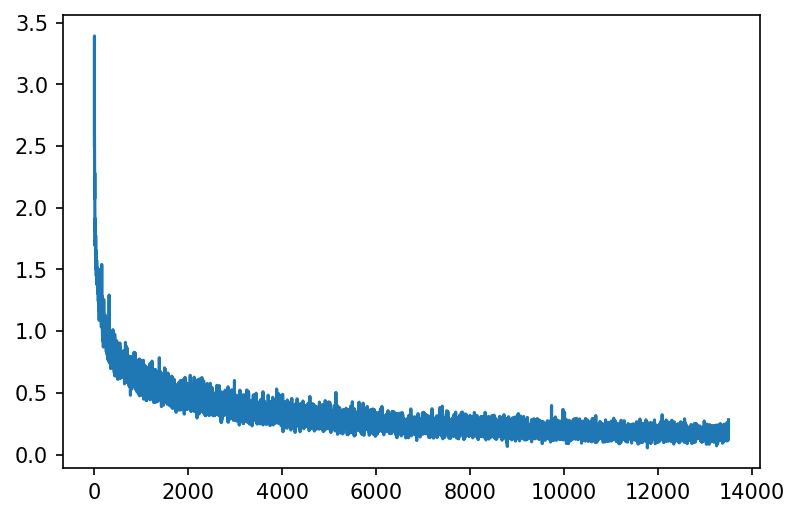

In [10]:
all_losses = history.batch_loss
plt.figure(dpi=150)
plt.plot(range(len(all_losses)), all_losses)
plt.show()

In our case, we used validation and therefore there exists a `val_loss` property on the history object. Theoretically, we would also be able to plot `val_accuracy` as all metrics are recorded in the history object as well.

In [11]:
import numpy as np

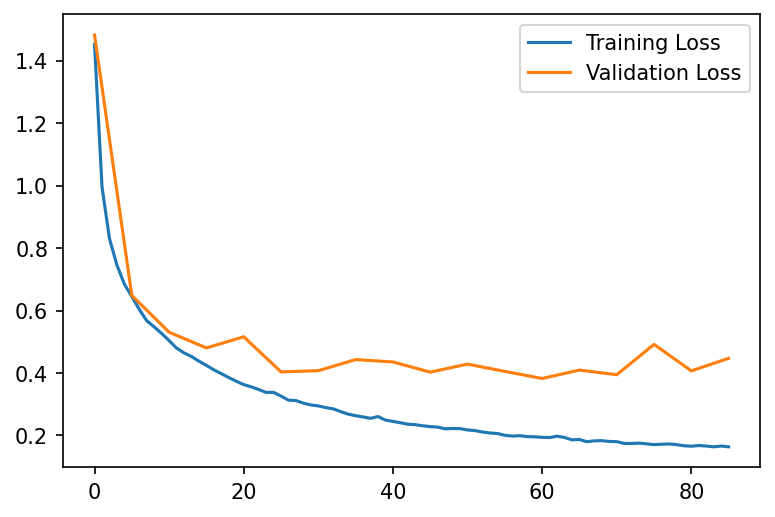

In [12]:
plt.figure(dpi=150)
plt.plot(range(len(history.loss)), history.loss, label='Training Loss')
plt.plot(np.array(range(len(history.val_loss))) * 5, history.val_loss, label='Validation Loss')
plt.legend()
plt.show()

As we can see, the losses are starting to diverge and the generalization gap becomes larger starting from epoch 25. However, the lowest validation loss was obtained after epoch 61.

### Evaluating the Model

Lastly, we want to evaluate the performance of our model. For this, we use our test data and call `evaluate` on the model. We are interested only in a single metric, the accuracy.

The returned value is a dictionary which provides the metrics that were recorded. In our case, the only metric is `accuracy`.

In [13]:
evaluation = engine.evaluate(
    test_loader,
    callbacks=[
        xnn.PredictionProgressLogger()
    ],
    metrics={
        'accuracy': X.accuracy
    }
)

 [Elapsed 0:00:01 | 3.16 it/s]                                                      


In [14]:
print(f"Our model achieves an accuracy of {evaluation['accuracy']:.2%}.")

Our model achieves an accuracy of 86.46%.


## Using GPUs

As PyBlaze is a framework dedicated for large-scale machine learning, it has first-class support for GPUs. In fact, in order to run training and evaluation on a GPU, **you do not have to do anything**. In fact, if you had a GPU at your disposal when running this tutorial, you already used it. Generally, PyBlaze will use all available GPUs automatically, speeding up training as much as possible.

If you have multiple GPUs and want to use a specific one, just pass `gpu=<ID>` to any of the functions above. Likewise, you can select a subset of GPUs by providing `gpu=[<ID1>, <ID2>, …]` or no GPU at all by using `gpu=False`.

A special case is `gpu=True` which chooses a single GPU: the one with the most amount of free memory.